## Jesús Miguel Sepúlveda Suárez
### Trabajo galaxias parte II

In [1]:
from astropy.io import fits
from scipy.optimize import leastsq 
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
import matplotlib.ticker as tck
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition  # Para dimensionar altura de colorbar
import random
import astropy.convolution
from scipy.special import factorial
from scipy.stats import poisson

# <span style = 'color:green'> Modelo exponencial de la galaxia

In [2]:
def Model_Exponential(param, image):
    """
    Función que crea el modelo exponencial de la galaxia en cualquiera de las dos longitudes de onda
    """
    
    exponential = np.zeros(image.size)

    x0  = param[0]
    y0  = param[1]
    amp = param[2]
    r0  = param[3]
    phi = np.deg2rad(param[4])
    
    x  = np.arange(image.shape[0])
    y  = np.arange(image.shape[1])
    xx, yy = np.meshgrid(x,y)
    #-----------------------------------------------------------
    r   = np.sqrt( ( (xx- x0)/np.cos(phi)  )**2 + (yy - y0)**2 )
    exponential = amp*np.exp(-r/r0)
    
    return exponential, r

# <span style = 'color:green'> Función error y ajuste de modelo

In [3]:
def Error_Func(param, image):
    """
    Función que calcula el error del modelo planteado
    """
    exponential, r = Model_Exponential(param, image)
    chi            = np.ravel(image - exponential)
    return chi

In [4]:
def Error_Func1(param, image):
    """
    Función que calcula el error del modelo planteado
    """
    exponential, r = Model_Exponential(param, image)
    chi            = np.ravel(((image - exponential)**2)/exponential)
    return chi

In [5]:
def Func_Model(image, amp, r0, phi):
    """
    Función que ajuste el modelo de cualquiera de las dos longitudes de onda por mínimos cuadrados
    """
    x0 = image.shape[0]/2
    y0 = image.shape[1]/2
    
    param = [x0, y0, amp, r0, phi]
    best_params1, success = leastsq(Error_Func, param, args= (image))
    phi = best_params1[4]
    L_model, r = Model_Exponential(best_params1, image)
    
    return L_model, r, best_params1

# <span style = 'color:green'> Función error y ajuste de la gaussiana

In [6]:
def ErrorFunc(tpl,x,y):
    """
    Funcion que calcula el error de una gaussiana
    """
    gauss = make_gaussian(tpl,x)
    chi = np.ravel(((y-gauss)**2)/gauss)
    return chi

In [7]:
def make_gaussian(tpl,x):
    """
    Funcion que hace una gaussiana a partir de una tupla y el dominio de los datos
    """
    mu = tpl[0]
    sigma = tpl[1]
    A = tpl[2]
    gauss = A*np.exp(-((x-mu)**2)/2/sigma**2)
    return gauss

# <span style = 'color:green'> Función para hacer un histograma

In [8]:
def histograma(image):
    """
    Funcion que hace un histograma apartir de los datos y regresa los valores de x,y que son sus posiciones, mu
    es la media y sigma es su desviacion estandar
    """
    corte_noise = image[:]
    h = np.histogram(corte_noise,bins=20)
    y = h[0]/np.max(h[0]) # Se hace que su maximo valor sea 1 para que se pueda observar mucho mejor
    x = (h[1][1:] + h[1][:-1])/2
#     plt.bar(x,y)
#     plt.title("Histograma")
#     plt.plot(x,y,"or")
    mu = np.mean(corte_noise[:])
    sigma = np.std(corte_noise[:])
    return x,y,mu,sigma

# <span style = 'color:green'> Lectura de los datos de la galaxia

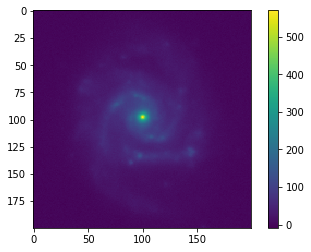

In [9]:
datos = fits.open("1_f850lp.fits")
datos = datos[0].data
plt.imshow(datos)
plt.colorbar()

# <span style = 'color:green'> Calculos del ruido y su aproximacion gaussiana
Primero se tomaran muestras de las 4 esquinas de los datos para poder mostrar su histograma y cual es su comportamiento.

In [10]:
lado1= datos[0:20,0:20] # Se guarda el corte de los datos
lado2= datos[180:200,0:20]
lado3= datos[0:20,180:200]
lado4= datos[180:200,180:200]
nueva=np.concatenate((lado1,lado2), axis=0) # Se concatenan los datos 
nueva1=np.concatenate((lado3,lado4), axis=0)
nueva2=np.concatenate((nueva,nueva1), axis=1)

Los diferentes histogramas de las 4 esquinas de los datos

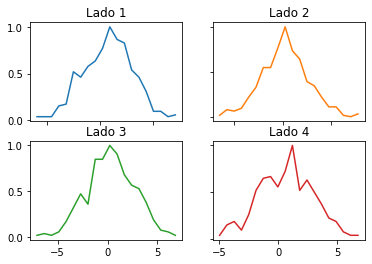

In [11]:
x1,y1,mu1,sigma1 = histograma(lado1)
x2,y2,mu2,sigma2 = histograma(lado2)
x3,y3,mu3,sigma3 = histograma(lado3)
x4,y4,mu4,sigma4 = histograma(lado4)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x1, y1)
axs[0, 0].set_title('Lado 1')
axs[0, 1].plot(x2, y2, 'tab:orange')
axs[0, 1].set_title('Lado 2')
axs[1, 0].plot(x3, y3, 'tab:green')
axs[1, 0].set_title('Lado 3')
axs[1, 1].plot(x4, y4, 'tab:red')
axs[1, 1].set_title('Lado 4')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [12]:
# Se almacenan los datos en una lista
lista=[]
for i in range(40):
    for j in range(40):
        lista.append(nueva2[i,j])

kito=np.array(lista)
kol=np.float64(kito) # Se tiene que hacer la conversion de datos a float64 dado que los datos estan en float32
kol                  # y marca error al hacer algunos calculos

array([-3.73821878, -4.09866476,  4.01053858, ...,  0.56825405,
       -2.55961323, -2.58816767])

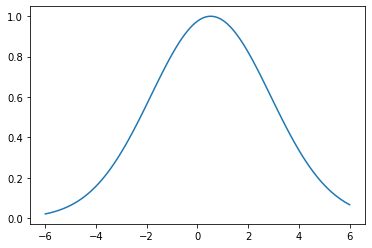

In [13]:
# Se crea una gaussiana con los valores de la media y desviacion estandar de los datos
mu = np.mean(kol)
sigma = np.std(kol)
xg = np.arange(-6,6.1,0.1)
tpl = [mu,sigma,1]
yg = make_gaussian(tpl,xg)
plt.plot(xg,yg)

(-6, 6)

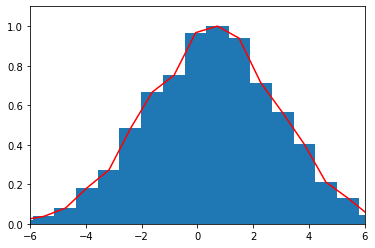

In [52]:
hist = np.histogram(kol,bins=20) #
yr = hist[0]/np.max(hist[0])
xr = (hist[1][1:] + hist[1][:-1])/2
plt.bar(xr,yr)
plt.plot(xr,yr, "-r")
plt.ylim((0,1.1))
plt.xlim((-6,6))

In [50]:
para = [0.5,2.5,1]
best_param, success = leastsq(ErrorFunc,para, args= (xr,yr))
print(best_param)

[0.5333044  2.3831347  0.96498289]


(20,)

(-6, 6)

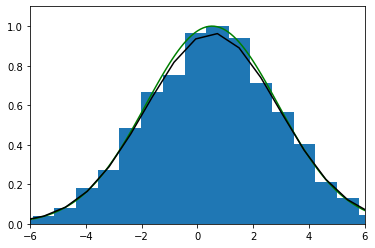

In [77]:
yh = make_gaussian(best_param,xr)
plt.bar(xr,yr)       # Datos 
plt.plot(xg,yg,"-g") # Gaussiana que deberia dar
plt.plot(xr,yh,"-k") # Gaussiana que da con los mejores parametros
plt.ylim((0,1.1))
plt.xlim((-6,6))

# <span style = 'color:green'> Ajuste del modelo

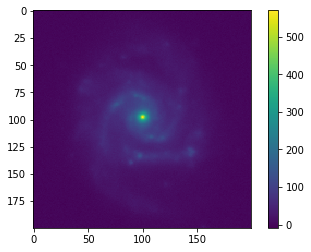

In [17]:
# Datos de la galaxia
datos = fits.open("1_f850lp.fits")
datos = datos[0].data
plt.imshow(datos)
plt.colorbar()

Se hara el ajuste del modelo con la funcion "Func_Model"

In [19]:
phi0 = 30
model, r, params = Func_Model(datos, 500 , 3, phi0) 
print(params)
x0  = params[0]
y0  = params[1]
amp = params[2]
r0  = params[3]
phi = params[4]

[ 99.72515099  97.86724142 224.27678833  24.38656735  16.38156269]


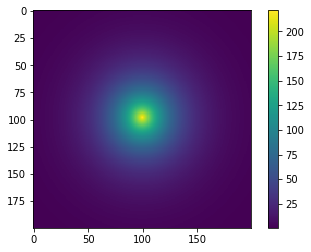

In [20]:
plt.imshow(model)
plt.colorbar()

In [21]:
mu = np.mean(kol[:])
sigma = np.std(kol[:])
sky = mu+2*sigma
sky

5.237514272414089

In [22]:
# Se hace una mascara con el calculo del ruido del cielo para luego quitarlo
datos_m = datos.copy()
model_m = model.copy()
mask = (model < sky)
datos_m[mask] = 0
model_m[mask] = 0
ere = np.arange(0,90,5)
expo = amp*np.exp(-ere/r0)
mask.sum()

14692

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


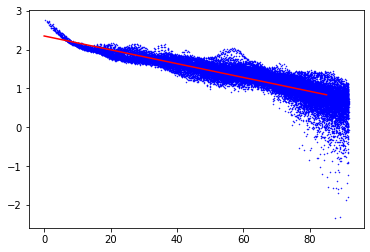

In [23]:
# Como decae el radio respecto a la galaxia
plt.plot(r[:],np.log10(datos_m[:]),".b",markersize=1)
plt.plot(ere,np.log10(expo),"-r",markersize=1)
plt.show()

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  


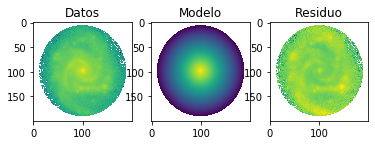

In [24]:
# Datos, modelo y residuo sin el ruido
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('Datos')
ax1.imshow(np.log10(datos_m))
ax2.set_title('Modelo')
ax2.imshow(np.log10(model_m))
ax3.set_title('Residuo')
ax3.imshow(np.log10(datos_m)-np.log10(model_m))

# <span style = 'color:green'> Proceso itaritivo

In [25]:
# Se ajusta de nuevo con los nuevos datos
phi0 = 30
model1, r, params = Func_Model(datos_m, 500 , 3, phi0) 
print(params)
x0  = params[0]
y0  = params[1]
amp = params[2]
r0  = params[3]
phi = params[4]


[ 99.71600388  97.84510326 227.03057135  23.98688551  15.45969576]


/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'color'
  This is separate from the ipykernel package so we can avoid doing imports until


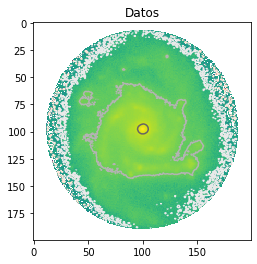

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'color'
  import sys


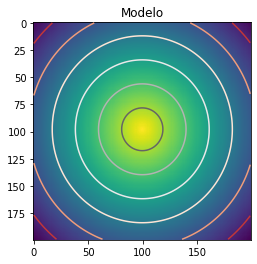

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'color'
  # This is added back by InteractiveShellApp.init_path()


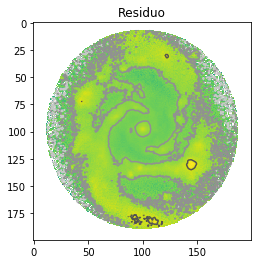

In [60]:
plt.title('Datos')
plt.imshow(np.log10(datos_m),zorder=1)
plt.contour(np.log10(datos_m),color="black",zorder=10, cmap='RdGy')
plt.show()
plt.title('Modelo')
plt.imshow(np.log10(model1),zorder=1)
plt.contour(np.log10(model1),color="black",zorder=10, cmap='RdGy')
plt.show()
plt.title('Residuo')
plt.imshow((np.log10(datos_m))-(np.log10(model1)),zorder=1)
plt.contour((np.log10(datos_m))-(np.log10(model1)),color="black",zorder=10, cmap='RdGy')

# <span style = 'color:green'> Convolución

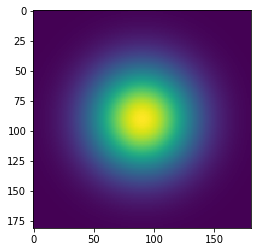

In [66]:
desv = (np.std(datos_m)) # Saco la desviacion estandar de los datos para pasarla de parametros a la convolucion
psf = astropy.convolution.Gaussian2DKernel(desv,x_size=181,y_size=181)
smooth = astropy.convolution.convolve(datos_m,psf)
plt.imshow(psf)

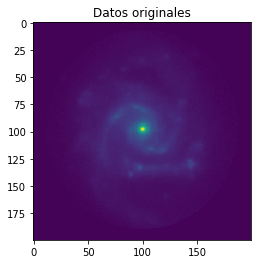

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'color'
  


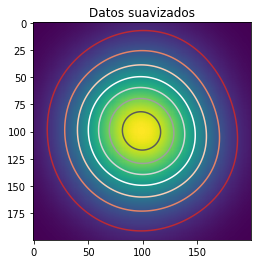

In [67]:
plt.title('Datos originales')
plt.imshow(datos_m)
plt.show()
plt.title('Datos suavizados')
plt.imshow(smooth)
plt.contour((smooth),color="black",zorder=10, cmap='RdGy')

# <span style = 'color:green'> Validación de la metodologia de ajuste
Se empiezan a crear modelos con datos sinteticos para probar que tan bueno es ajuste que se le esta haciendo y en cuanto es su margen de error

In [68]:
modelo,ere = Model_Exponential([90,110,1e8,3,50], datos)

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The following kwargs were not used by contour: 'color'
  


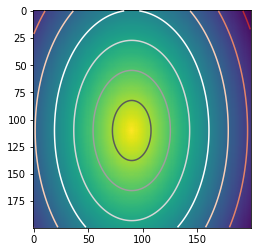

In [69]:
plt.imshow(np.log10(modelo),zorder=1)
plt.contour(np.log10(modelo),color="black",zorder=10, cmap='RdGy')

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'color'
  import sys


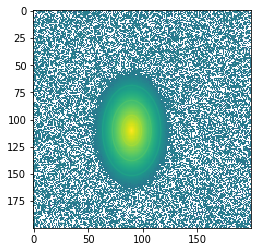

In [71]:
# Al modelo de datos sinteticos de galaxia le vamos a agragar un ruido con una distribucion normal para ver como
# sigue funcionando el ajuste
mu = np.mean(kol[:])
sigma = np.std(kol[:])
modelo_noise = modelo + np.random.normal(loc=mu,scale=sigma,size=modelo.shape)
plt.imshow(np.log10(modelo_noise),zorder=1)
plt.contour(np.log10(modelo_noise),color="black",zorder=10)

In [72]:
# Se pueden obtener los parametros que da el ajuste y compararlos con los datos que sabemos que tiene que dar
model5, r, params = Func_Model(modelo_noise, 1e6 , 3, 80)
print(params)
x0  = params[0]
y0  = params[1]
amp = params[2]
r0  = params[3]
phi = params[4]

[9.00000000e+01 1.10000000e+02 9.99999978e+07 3.00000014e+00
 5.00000003e+01]


In [73]:
chi = Error_Func(params, modelo_noise)
x2=chi.sum()
x2

21405.94373933704

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'color'
  """


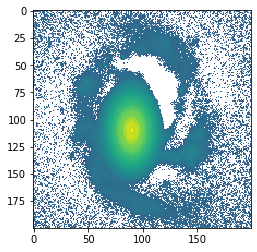

In [74]:
# Al modelo que se le sumo el ruido tambien se le agrega el residuo de datos-modelo en el primer ajuste y 
# ver como varia el ajuste en cuanto se daña o mejora
modelo_suma=modelo_noise+(datos-model)
plt.imshow(np.log10(modelo_suma),zorder=1)
plt.contour(np.log10(modelo_suma),color="black",zorder=10)
x2

In [75]:
# Usando los mismo parametros pero con la suma del residuo se puede observar si mejora o empeora el ajuste de modelo
model5, r, params = Func_Model(modelo_suma, 1e6 , 3, 80)
print(params)
x0  = params[0]
y0  = params[1]
amp = params[2]
r0  = params[3]
phi = params[4]

[9.00000004e+01 1.09999999e+02 1.00000047e+08 2.99999601e+00
 5.00000165e+01]


In [76]:
chi = Error_Func(params, modelo_suma)
x2=chi.sum()
x2

39503.3651470332

# <span style = 'color:green'> Exploracion de incertidumbre en los resultados
Para la exploracion de parameros se hace a fuerza bruta variando los parametros con ciclos for y ir comparando sus errores para observar en cual da la mejor combinacion y compararla con la que nos da el ajuste

In [43]:
base=1e20
for i in np.arange(99.909,99.91,0.0001):
    for k in np.arange(98.909,98.91,0.0001):
        for j in np.arange(225.300,225.301,0.0001):
            for l in np.arange(25.900,25.901,0.0001):
                for p in np.arange(15.388,15.389,0.0001):
                    error=Error_Func1([i,k,j,l,p], datos)
                    x2= (error).sum() 
                    if x2<=base:
                        x=i
                        y=k
                        amp=j
                        rad=l
                        ang=p
                        base=x2
                        mejor=x2
                        
print(x,y,amp,rad,ang,mejor)

99.90990000000004 98.90990000000004 225.3 25.9 15.388899999999998 150298.14762515834


In [46]:
# Chi2 del ajusto del modelo
error = Error_Func1([99.71600388, 97.84510326, 227.03057135, 23.98688551, 15.45969576], datos)
x2 = (error).sum()
x2

172619.32535930735

In [81]:
def Func_Model2(image, amp, r0, phi):
    """
    Función que ajuste el modelo de cualquiera de las dos longitudes de onda por mínimos cuadrados
    """
    
    param = [amp, r0, phi]
    best_params1, success = leastsq(Error_Func2, param, args= (image))
    
    return best_params1 

In [82]:
def Error_Func2(param, image):
    """
    Función que calcula el error del modelo planteado
    """
    exponential = Model_Exponential2(param, image)
    chi         = np.ravel(image - exponential)
    return chi

In [83]:
def Model_Exponential2(param, image):
    """
    Función que crea el modelo exponencial de la galaxia en cualquiera de las dos longitudes de onda
    """
    
    exponential = np.zeros(image.size)

    amp = param[0]
    r0  = param[1]
    phi = np.deg2rad(param[2])
    
    x  = np.arange(image.shape[0])
    y  = np.arange(image.shape[1])
    xx, yy = np.meshgrid(x,y)
    #-----------------------------------------------------------
    r   = np.sqrt( ( (xx)/np.cos(phi)  )**2 + (yy)**2 )
    exponential = amp*np.exp(-r/r0)
    
    return exponential

In [85]:
def Error_Func3(param, image):
    """
    Función que calcula el error del modelo planteado
    """
    exponential, r = Model_Exponential(param, image)
    chi            = np.ravel(((image - exponential)**2)/exponential)
    return chi  

In [86]:
def Error_Func3(param, image):
    """
    Función que calcula el error del modelo planteado
    """
    exponential, r = Model_Exponential(param, image)
    chi            = np.ravel(((image - exponential)**2)/exponential)
    return chi

In [87]:
x2=[]
for i in range(95,105,1):
    x2.append([])
    for j in range(95,105,1):
        parametros=Func_Model2(datos, 225, 9, 15)
        lol=Error_Func3([i, j, parametros[0], parametros[1], parametros[2]], datos)
        x2[i-95].append(lol.sum())

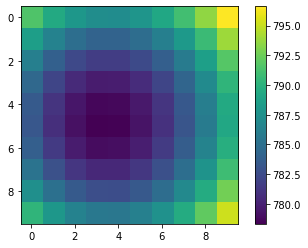

In [89]:
lop=np.array(x2)
# lop=np.sqrt(lop)
plt.imshow(lop)
plt.colorbar()